## Read the input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 3002, number of features = 3165
Number of samples = 750, number of features = 3165


In [2]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 34.29499053955078
Average OGT of the train set = 34.574623107910156


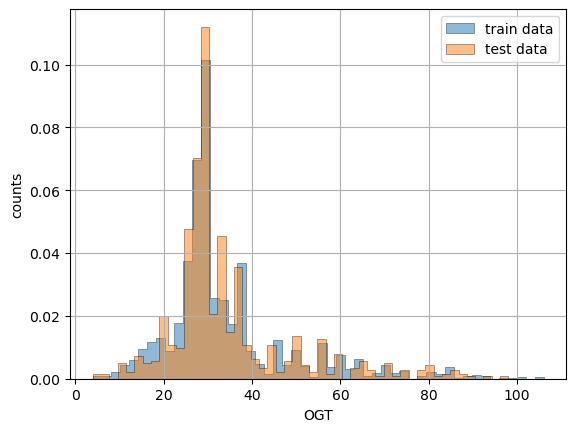

In [3]:
hist = plt.hist(y_train.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

## Initial prediction

In [3]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 5.93, R2 = 0.83
XGBoost baseline CV RMSE (all features) = 5.81, R2 = 0.85


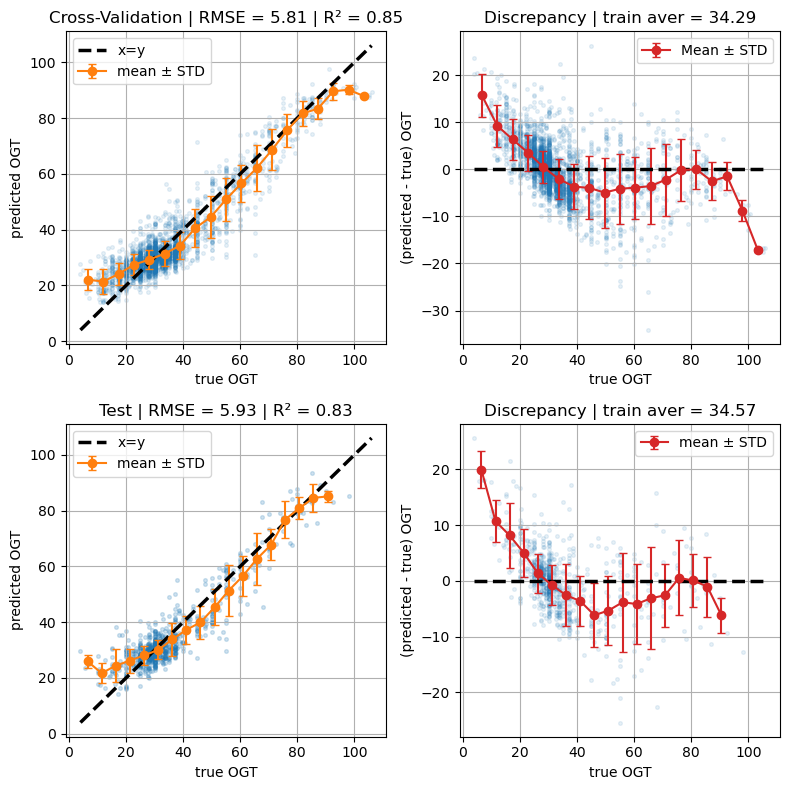

In [6]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

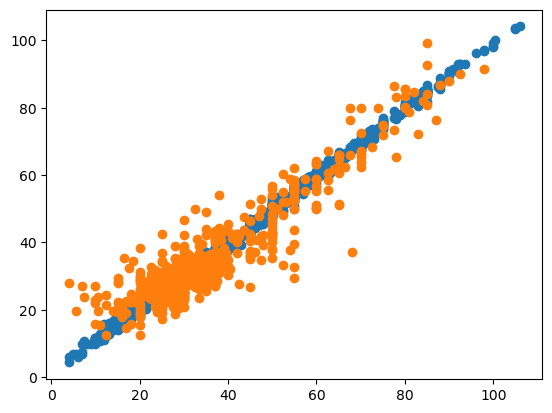

In [7]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())

#X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
preds = model.predict(X_train.cpu())
rmse_test = np.sqrt(mean_squared_error(y_train.cpu(), preds))
r2_test = r2_score(y_train.cpu(), preds)
plt.scatter(y_train.cpu(), preds)

preds = model.predict(X_test.cpu())
plt.scatter(y_test.cpu(), preds)

## Step 2: Train Models on Data Segments

num low = 920; num mid = 1000; num high = 1082;


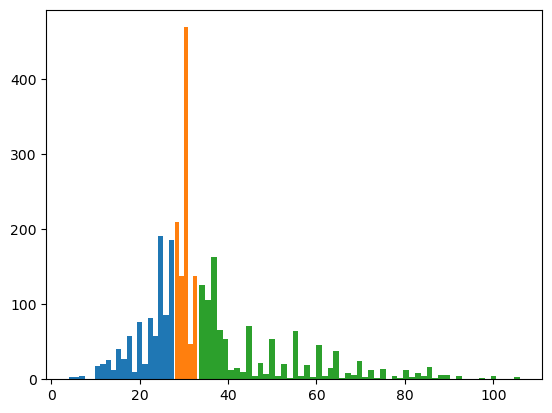

In [5]:
#y_train_log = np.log1p(y_train)
#y_test_log = np.log1p(y_test)

# Flatten y_train to 1D
y_train_flat = y_train.flatten()

# Compute quantiles from the flattened version
low_q = np.quantile(y_train_flat, 1/3)
high_q = np.quantile(y_train_flat, 2/3)

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask], y_train_flat[low_mask]
X_mid, y_mid   = X_train[mid_mask], y_train_flat[mid_mask]
X_high, y_high = X_train[high_mask], y_train_flat[high_mask]

plt.hist(y_low, bins=20)
plt.hist(y_mid, bins=5)
plt.hist(y_high, bins=55)

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

In [10]:
high_q

33.5

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05)

model_low  = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05).fit(X_low, y_low)
model_mid  = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05).fit(X_mid, y_mid)
model_high = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05).fit(X_high, y_high)

In [20]:
def evaluate_model(model, X_test, y_test, segment_name):
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"\nPerformance on {segment_name} segment:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    return r2, mae, rmse

In [21]:
# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()
# low_q = np.quantile(y_train.flatten(), 1/3)
# high_q = np.quantile(y_train.flatten(), 2/3)

# Create test masks
low_mask_test  = y_test_flat < low_q
mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
high_mask_test = y_test_flat >= high_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test], y_test_flat[low_mask_test]
X_test_mid, y_test_mid   = X_test[mid_mask_test], y_test_flat[mid_mask_test]
X_test_high, y_test_high = X_test[high_mask_test], y_test_flat[high_mask_test]

In [22]:
# Evaluate each model
evaluate_model(model_low,  X_test_low,  y_test_low,  "Low")
evaluate_model(model_mid,  X_test_mid,  y_test_mid,  "Mid")
evaluate_model(model_high, X_test_high, y_test_high, "High")


Performance on Low segment:
  R²   : 0.262
  MAE  : 3.363
  RMSE : 4.334

Performance on Mid segment:
  R²   : 0.054
  MAE  : 1.036
  RMSE : 1.338

Performance on High segment:
  R²   : 0.867
  MAE  : 4.243
  RMSE : 5.527


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.8669569492340088, 4.2430906, 5.527152)

In [23]:
gain_dict = model_low.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_low)
print(f"Tot gain in low model = {total_gain}")

gain_dict = model_mid.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_mid)
print(f"Tot gain in mid model = {total_gain}")

gain_dict = model_high.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_high)
print(f"Tot gain in high model = {total_gain}")

Tot gain in low model = 95.14921150401882
Tot gain in mid model = 7.171602025084198
Tot gain in high model = 347.59259729883365


## Step 3: Normalize Sensitivity via Target Transform or Weights


### Log-Transforming Target

In [10]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train_log.cpu(), X_test.cpu(), y_test_log.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 34.14, R2 = -4.61
XGBoost baseline CV RMSE (all features) = 0.20, R2 = 0.74


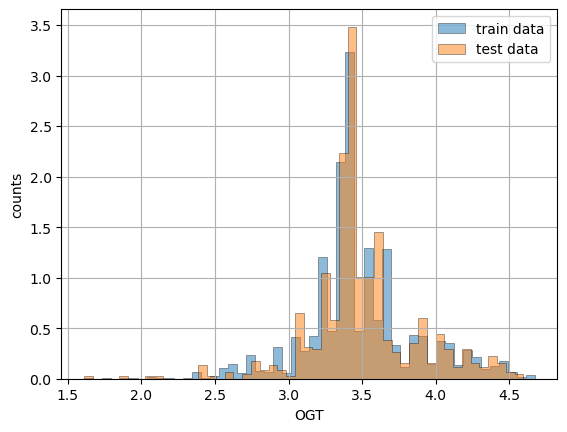

In [11]:
hist = plt.hist(y_train_log.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test_log.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

In [13]:
y_true_cv = np.expm1(y_true_cv)
y_pred_cv = np.expm1(y_pred_cv)
y_pred_test = np.expm1(y_pred_test)

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

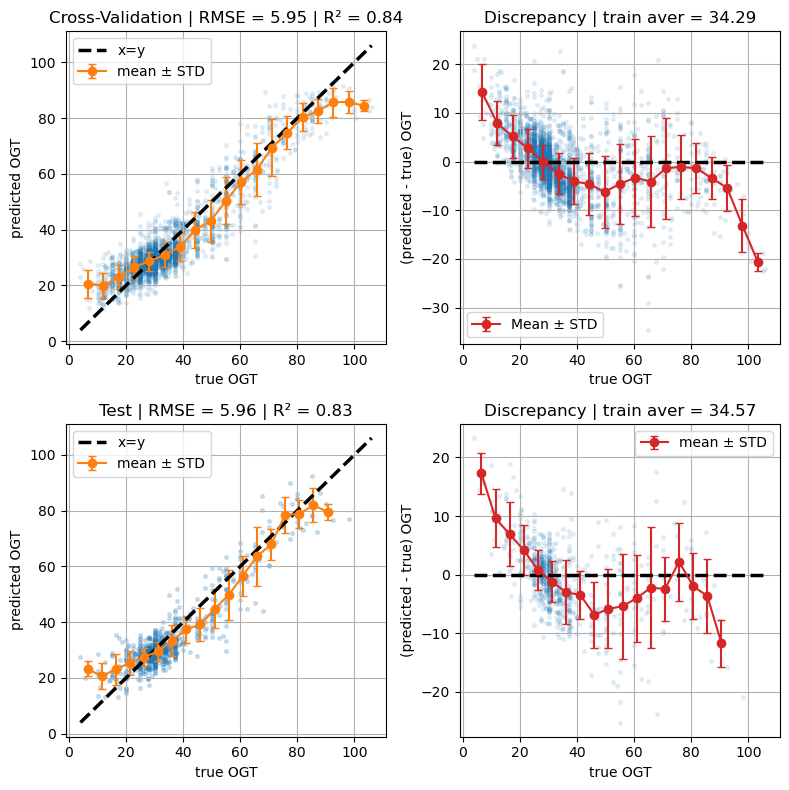

In [14]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

### Weighting Samples

In [14]:
from utils.utils import train_xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from utils.utils import train_xgboost, calculate_aver_std

weights = np.ones(len(y_train))
weights[y_train.squeeze() < low_q] = 1   # Upweight low tail
weights[y_train.squeeze() > high_q] = 0 # Downweight long tail

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=weights) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:723: FutureWarning: Pass `sample_weight` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBoost baseline test RMSE (all features) = 15.40, R2 = -0.14
XGBoost baseline CV RMSE (all features) = 15.58, R2 = -0.10


In [15]:
low_q

28.0

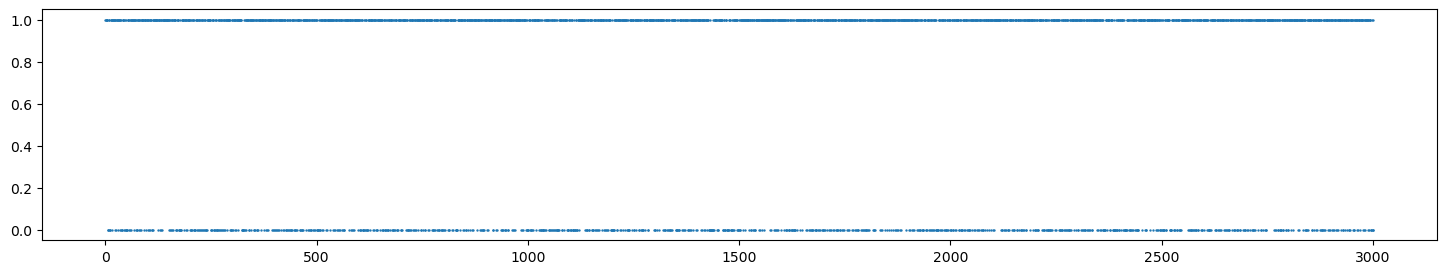

In [16]:
plt.figure(figsize=(18, 3))
plt.scatter(range(len(weights)), weights, s=0.5)

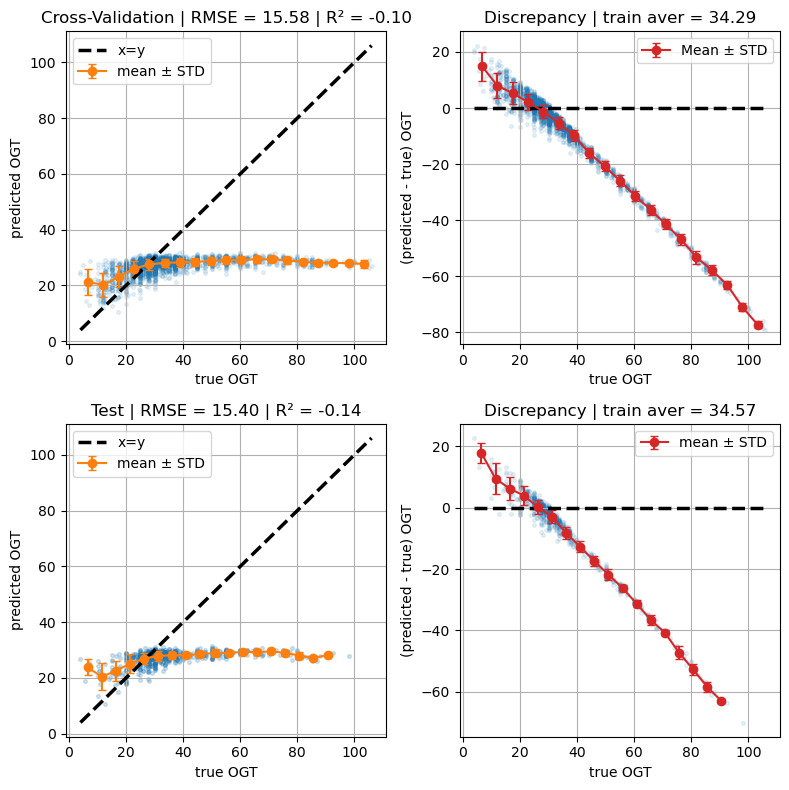

In [17]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

### Test Generalization Between Segments

In [16]:
y_low[:10]
preds

NameError: name 'preds' is not defined

In [22]:
preds = model_low.predict(X_low)
preds[:10]

array([23.6208  , 25.35663 , 25.27836 , 20.841986, 25.772318, 24.84976 ,
       19.884983, 26.390766, 25.685076, 19.68506 ], dtype=float32)

In [54]:
# y_low = np.expm1(y_low)
# y_mid = np.expm1(y_mid)
# y_high = np.expm1(y_high)


In [56]:
# y_test_low = np.expm1(y_test_low)
# y_test_mid = np.expm1(y_test_mid)
# y_test_high = np.expm1(y_test_high)

In [44]:
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
r2_test

-23.651071548461914

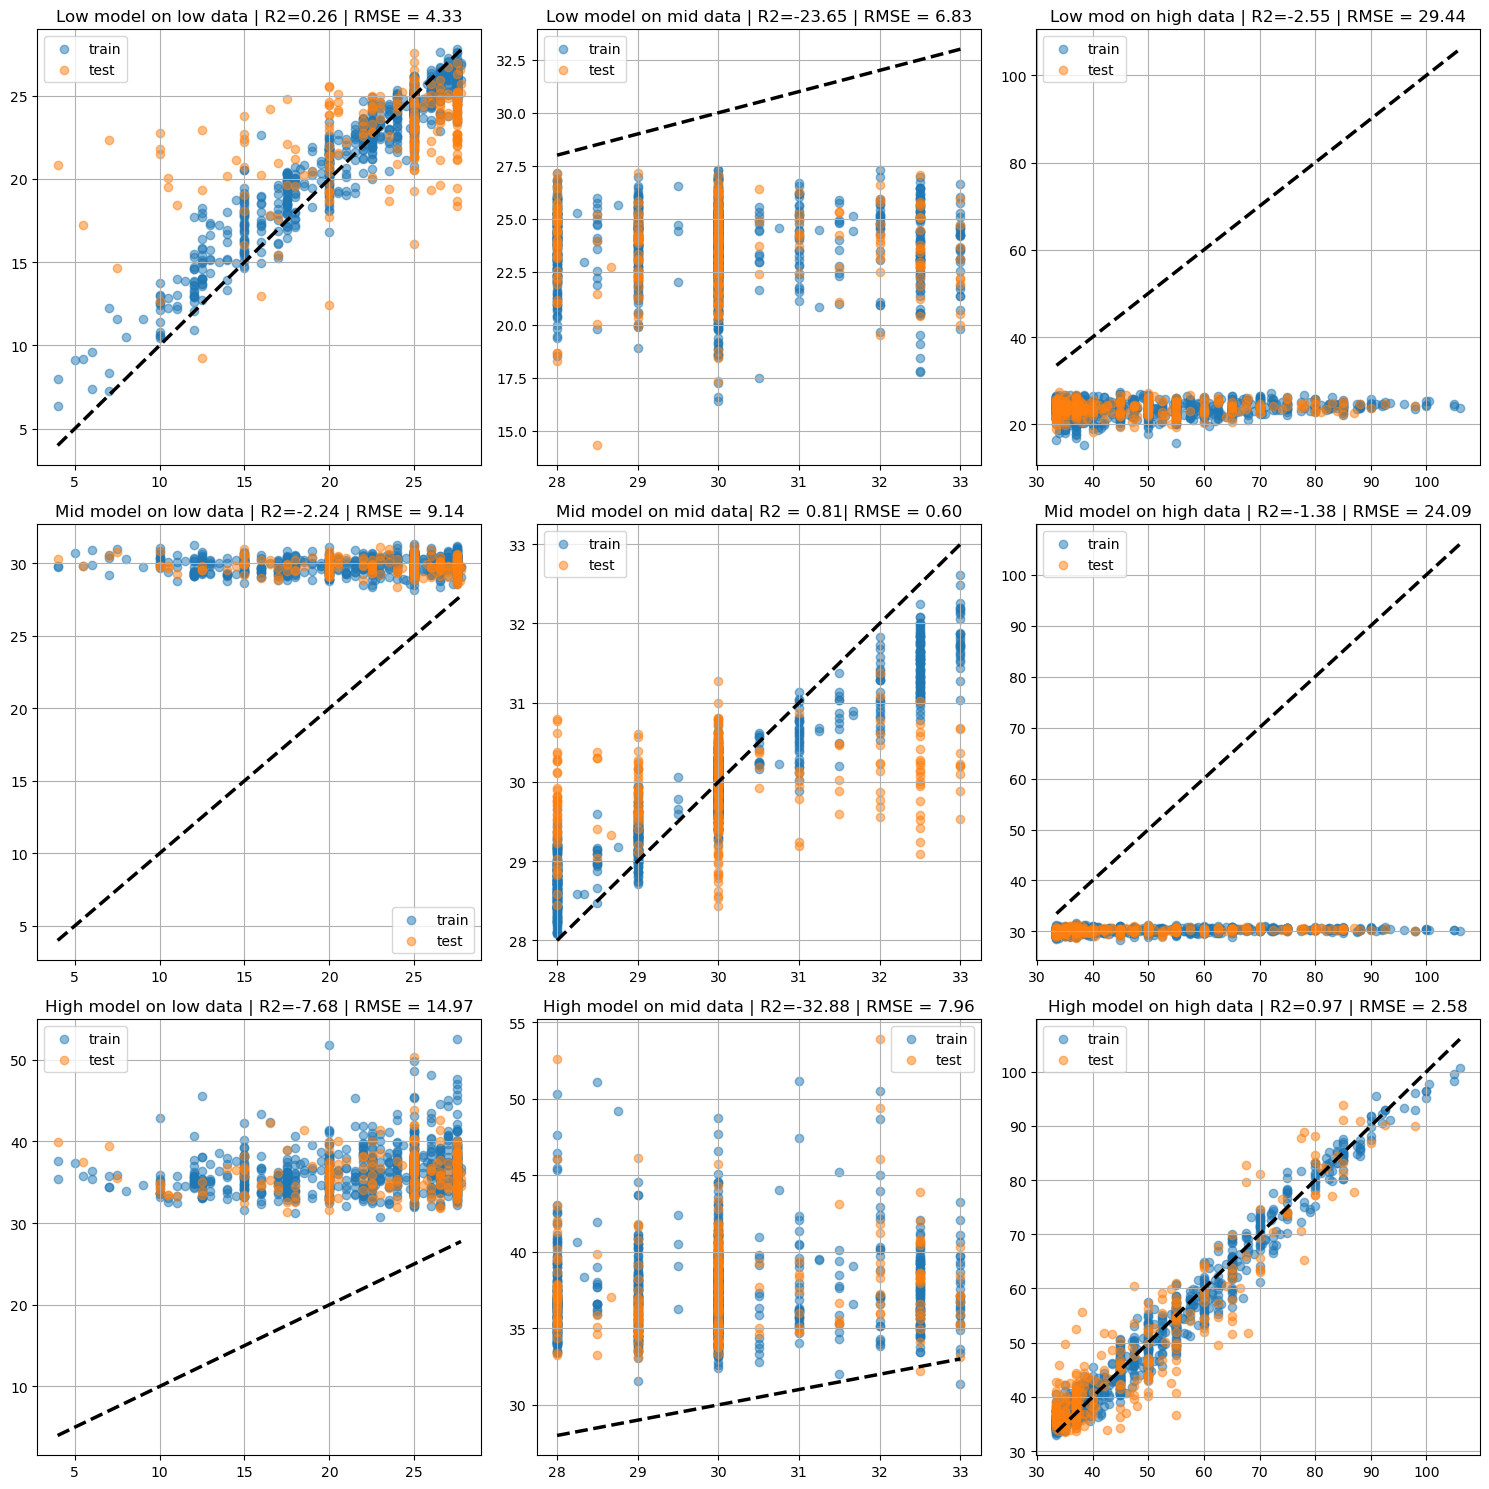

In [39]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1) 
preds = model_low.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
preds_test = model_low.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2) 
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 3) 
preds = model_low.predict(X_high)
rmse_test = np.sqrt(mean_squared_error(y_high, preds))
r2_test = r2_score(y_high, preds)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_low.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 4) 
preds = model_mid.predict(X_low)
rmse_test = np.sqrt(mean_squared_error(y_low, preds))
r2_test = r2_score(y_low, preds)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_low.flatten(), model_mid.predict(X_test_low), alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 5) 
preds = model_mid.predict(X_mid)
rmse_test = np.sqrt(mean_squared_error(y_mid, preds))
r2_test = r2_score(y_mid, preds)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), model_mid.predict(X_test_mid), alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on mid data| R2 = {r2_test:.2f}| RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 6) 
preds = model_mid.predict(X_high)
rmse_test = np.sqrt(mean_squared_error(y_high, preds))
r2_test = r2_score(y_high, preds)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_mid.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 7) 
preds = model_high.predict(X_low)
rmse_test = np.sqrt(mean_squared_error(y_low, preds))
r2_test = r2_score(y_low, preds)
plt.scatter(y_low, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_low.flatten(), model_high.predict(X_test_low), alpha = 0.5, label = "test")
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 8) 
preds = model_high.predict(X_mid)
rmse_test = np.sqrt(mean_squared_error(y_mid, preds))
r2_test = r2_score(y_mid, preds)
plt.scatter(y_mid, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_mid.flatten(), model_high.predict(X_test_mid), alpha = 0.5, label = "test")
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 9) 
preds = model_high.predict(X_high)
rmse_test = np.sqrt(mean_squared_error(y_high, preds))
r2_test = r2_score(y_high, preds)
plt.scatter(y_high, preds, alpha = 0.5, label = "train")
plt.scatter(y_test_high.flatten(), model_high.predict(X_test_high), alpha = 0.5, label = "test")
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

### Top important features

Top 10 most important features by gain in the low model:
K00876: 1028.49
K05812: 980.66
K03533: 931.67
K03563: 707.12
K13282: 681.75
K07154: 671.29
K04078: 627.05
K09978: 620.37
K07146: 619.31
K16554: 598.82


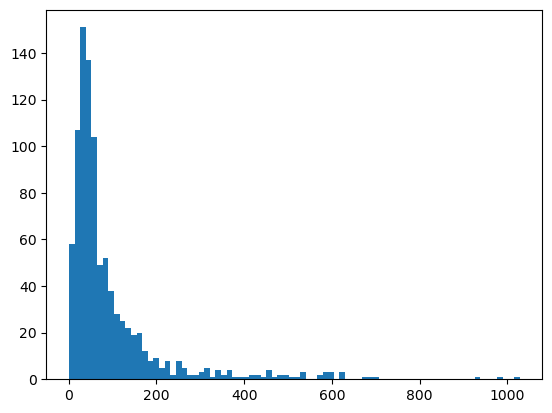

In [45]:
# Get feature importance scores (by gain)
gain_dict = model_low.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the low model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the mid model:
K05794: 36.98
K02106: 33.91
K05520: 32.12
K03549: 31.54
K10805: 29.92
K21688: 29.10
K23205: 28.92
K04762: 28.14
K02529: 28.04
K00453: 27.52


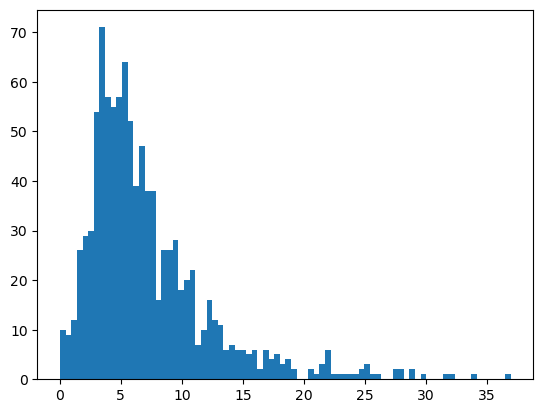

In [46]:
# Get feature importance scores (by gain)
gain_dict = model_mid.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the mid model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the high model:
K03170: 27735.65
K01622: 25184.38
K04043: 23809.37
K19091: 10852.37
K02346: 6141.13
K06416: 6053.71
K07007: 5362.43
K07015: 5237.19
K06951: 4961.61
K02499: 4729.92


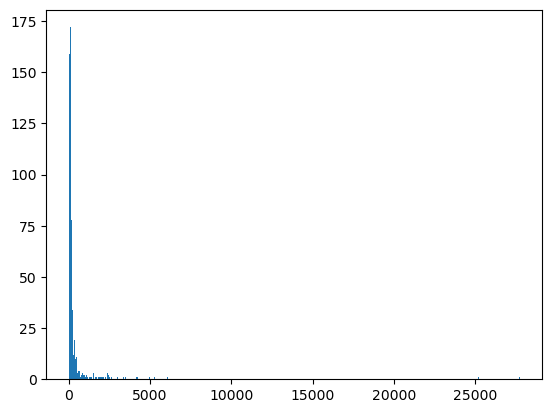

In [47]:
# Get feature importance scores (by gain)
gain_dict = model_high.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the high model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=800);

### Vizualization 

Shape of the projected data = (3002, 2)


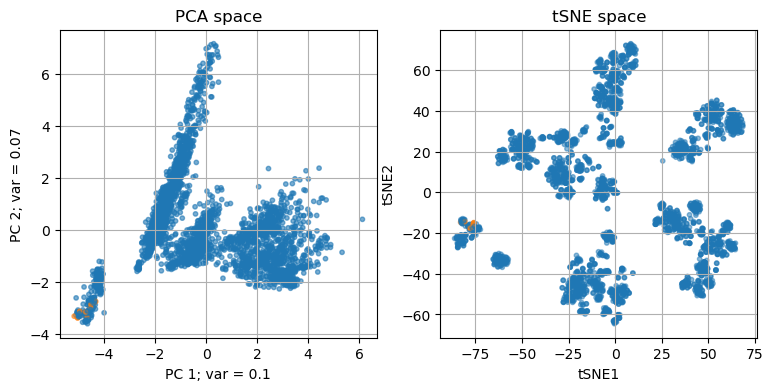

In [51]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>90  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

Shape of the projected data = (3002, 2)


Text(0.5, 0.98, 'Expression level of K05794')

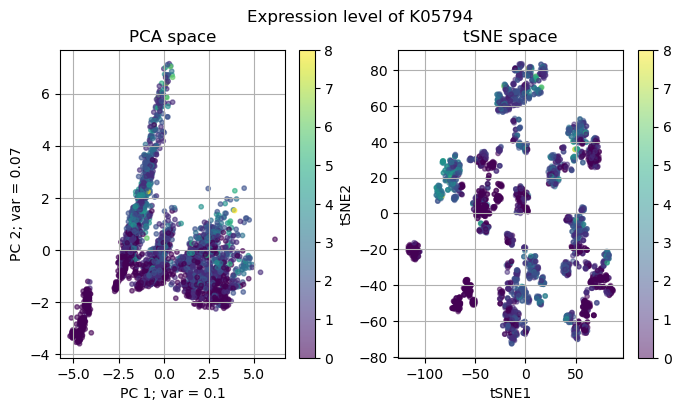

In [59]:
feature_name = 'K05794'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

In [58]:
max(feature_expression)


tensor(3, dtype=torch.int32)